<a href="https://colab.research.google.com/github/yiit8/My-Custom-Backbone-Model-for-Car-Detection/blob/main/Car_Obj_Detection_with_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Vehicle_detection.rar"  "/content/Vehicle_dataset"

In [ ]:
!pip install torchmetrics

In [4]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import cv2
import os
import glob
import time
import re
import random
import datetime
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from shapely.geometry import Polygon, Point
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

In [5]:
img_path = '/content/Vehicle_dataset/Vehicle_detection/train/images'
lbl_path = '/content/Vehicle_dataset/Vehicle_detection/train/labels'
img_list = glob.glob(os.path.join(img_path, "*.jpg"))
ann_list = glob.glob(os.path.join(lbl_path , "*.txt"))
print(len(img_list), len(ann_list))

10218 10218


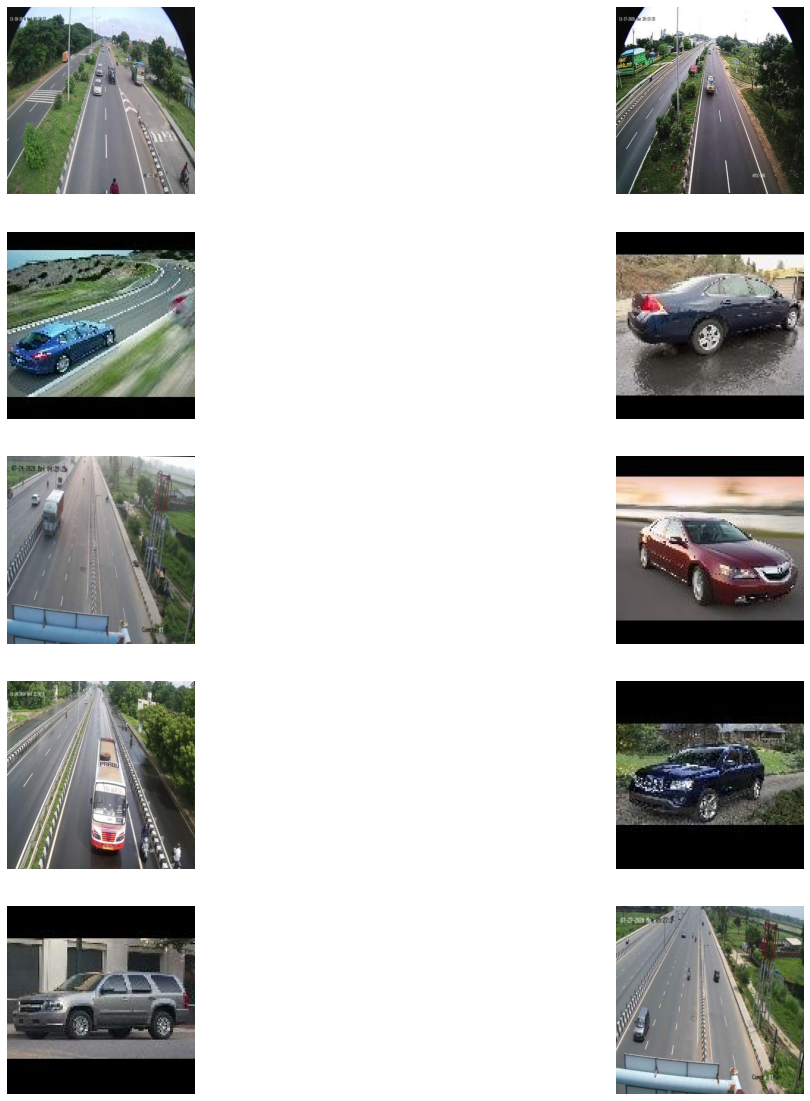

In [6]:
#plot some images 
plt.figure(figsize=(20,20))
for i, images in enumerate(img_list):
    if i > 9:
        break
    img = cv2.imread(images)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = Image.open(images)
    plt.subplot(5,2,i+1)
    plt.imshow(RGB_img)
    plt.axis('off')

In [7]:
#Function to get image name
def imname(path):
    file = os.path.basename(path)
    file_name = file[:-4]
    return file_name

# function to get values to plot
def img_ann(imname):

    img = cv2.imread(f'/content/Vehicle_dataset/Vehicle_detection/train/images/{imname}.jpg')
    imr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df = pd.read_csv(f'/content/Vehicle_dataset/Vehicle_detection/train/labels/{imname}.txt', sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])

    # rescale coordinates for visualization
    df_scaled = df.iloc[:, 1:]
    df_scaled[['x1', 'w']] = df_scaled[['x1', 'w']] * imr.shape[1]
    df_scaled[['y1', 'h']] = df_scaled[['y1', 'h']] * imr.shape[0]
    return imr, df_scaled

#Function to plot images
def draw_annot(img, df):
    # create figure and axes
    fig,ax = plt.subplots(1, figsize=(15,15))
    # display the image
    ax.imshow(img)
    for box in df.values:
        # create a Rectangle patch
        rect = patches.Rectangle((box[0]-(box[2]/2),box[1]-(box[3]/2)),box[2],box[3],linewidth=3,edgecolor='g',facecolor='none')
    # add the patch to the axes
        ax.add_patch(rect)
    plt.axis('off')    
    plt.show()

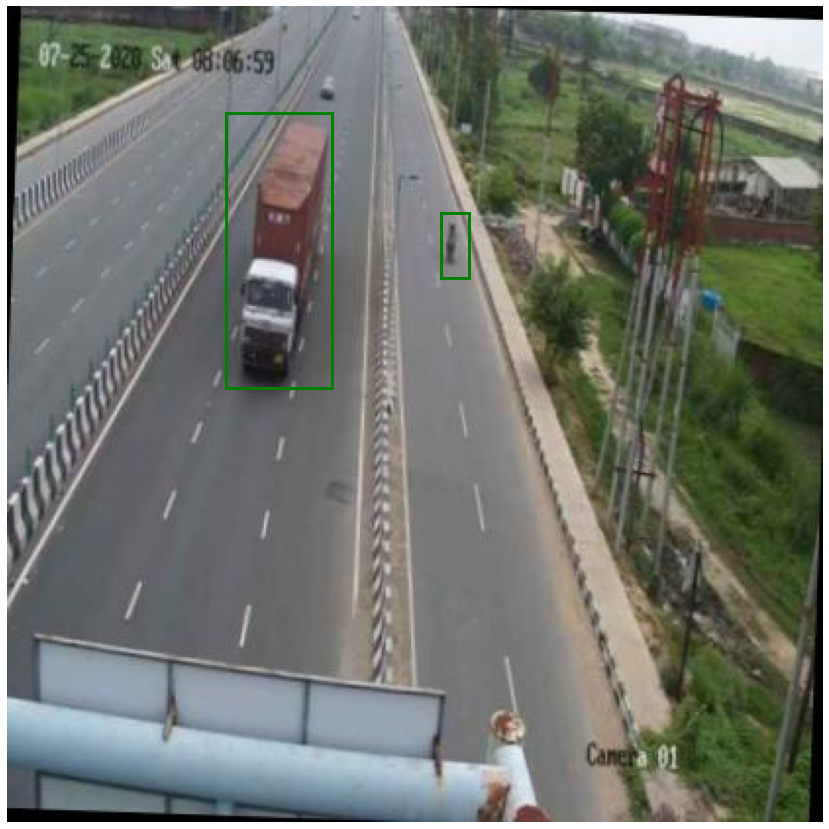

In [8]:
imgname = imname('/content/Vehicle_dataset/Vehicle_detection/train/labels/Highway_798_2020-07-30_jpg.rf.7f820d0b87649b211bb1722b50ed4bf6.txt')
img, df = img_ann(imgname)
# print(df)
draw_annot(img, df)

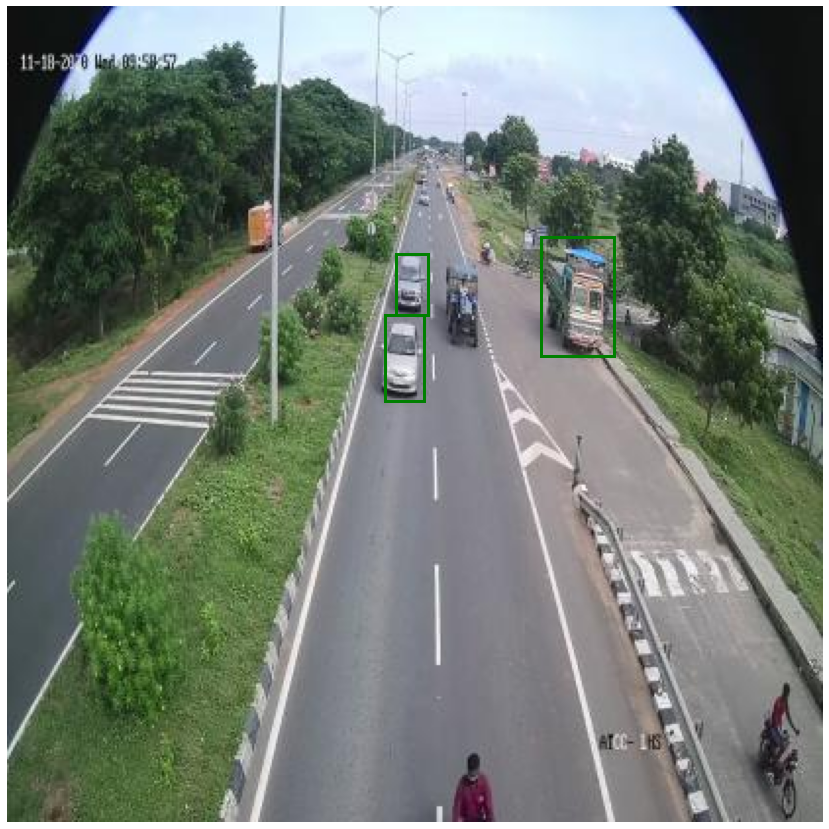

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


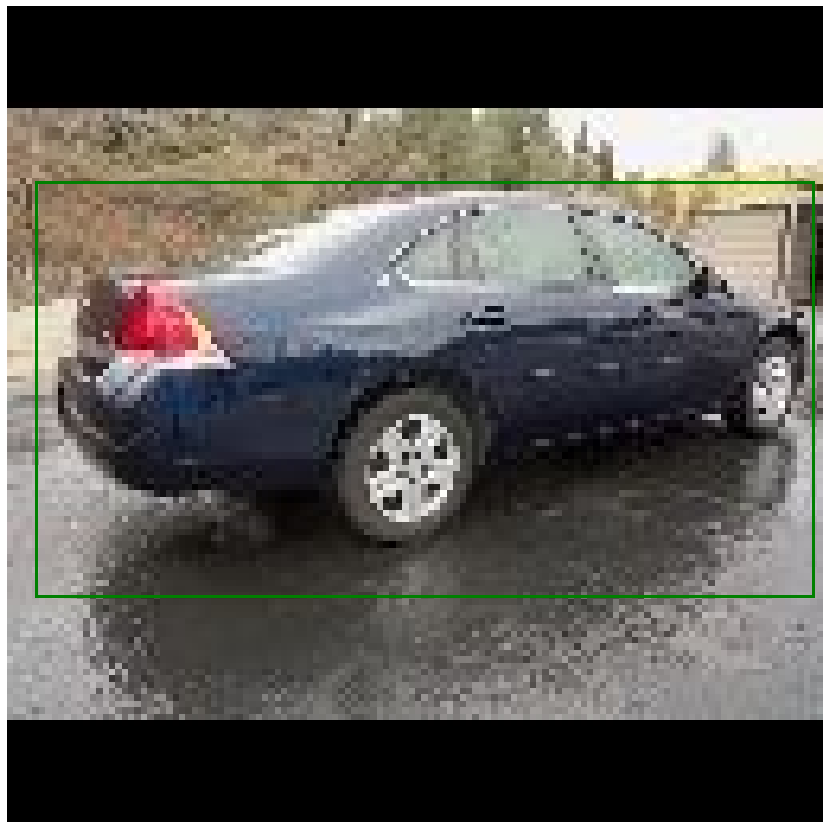

In [9]:
#Plot some images and their annotations
for i, images in enumerate(img_list):
    if i > 4:
        break
    imgname = imname(images)
    img, df = img_ann(imgname)
    draw_annot(img, df)    

In [10]:
# making dirs to segregate images & annotations & also to save best trained model
os.makedirs('./annotations',exist_ok = True)
os.makedirs('./images', exist_ok = True)
os.makedirs('./test', exist_ok = True)
os.makedirs('./savedmodel', exist_ok = True)

In [11]:
trainval_list, test_list = train_test_split(img_list, test_size=0.01, shuffle=True)
print(len(trainval_list), len(test_list))

10115 103


In [12]:
#Get train and validation annotations list
trainval_ann_list = []
ann_path = '/content/Vehicle_dataset/Vehicle_detection/train/labels'
for file in trainval_list:
    img_name = os.path.basename(file)
    file_name = img_name[:-4]
    ann_file = os.path.join(ann_path, file_name + '.txt')
    trainval_ann_list.append(ann_file)
    
len(trainval_ann_list)

10115

In [13]:
# Copy files from our img paths to our image folder in our working directory
def copy_files(filelist, dest):
    for file in filelist:
        shutil.copy(file, dest)
        
copy_files(trainval_list, './images')
copy_files(trainval_ann_list, './annotations')
copy_files(test_list, './test')


In [14]:
# Removing Image file with no annotations
annot_list_txt = glob.glob(os.path.join('/content/annotations' , "*.txt"))
train_img_jpg = glob.glob(os.path.join('/content/images',"*.jpg" ))
for file in train_img_jpg:
    name = os.path.basename(file)
    ann_file_name = os.path.join('/content/annotations', name[:-4] + '.txt')
    if os.path.exists(ann_file_name)==False:
        print(file)
        os.remove(file)
        print(f'{file} removed')

print(len(annot_list_txt))
print(len(train_img_jpg))

10115
10115


In [15]:
train_img_jpg = glob.glob(os.path.join('./images' , "*.jpg"))
print(len(train_img_jpg))
print(len(annot_list_txt))

10115
10115


In [ ]:
!pip install pylabel

In [ ]:
from pylabel import importer
#setting up paths
path_to_annotations = '/content/annotations'
path_to_images = '/content/images'

classes = ['auto','bus','car','lcv','motorcycle','multiaxle','tractor','truck']

dataset = importer.ImportYoloV5(path=path_to_annotations, path_to_images=path_to_images, cat_names=classes,
    img_ext="jpg", name="Vehicles")

dataset.export.ExportToVoc('./annotations')

Number of images: 10115


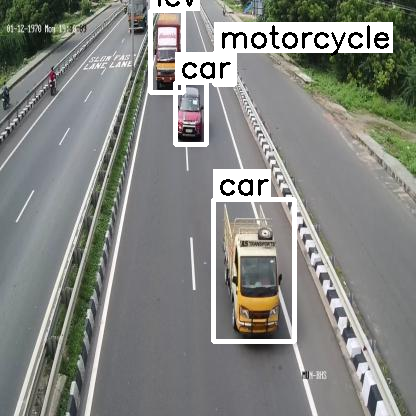

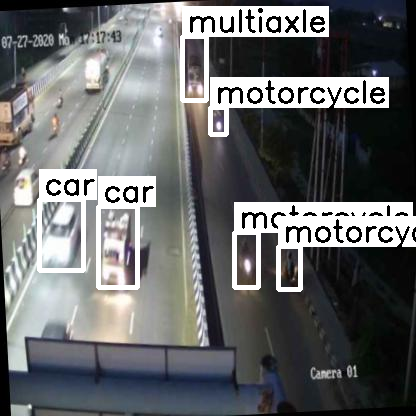

In [18]:
print(f"Number of images: {dataset.analyze.num_images}")
from IPython.display import Image, display
display(dataset.visualize.ShowBoundingBoxes(70))
display(dataset.visualize.ShowBoundingBoxes(50))

In [19]:
#Remove Images without annotations
#Just to double check
ann_list_xml = glob.glob(os.path.join('/content/annotations' , "*.xml"))
img_list_jpg = glob.glob(os.path.join('/content/images' , "*.jpg"))
print(len(ann_list_xml))
print(len(img_list_jpg))
for file in img_list_jpg:
    name = os.path.basename(file)
    ann_file_name = os.path.join('/content/annotations', name[:-4] + '.xml')
    if os.path.exists(ann_file_name)==False:
        print(ann_file_name)
        os.remove(file)
        print(f'Removed {file}')
print(len(img_list_jpg))

10115
10115
10115


In [20]:
# Extract info. from xml files
class XmlParser(object):

    def __init__(self,xml_file, IMG_PATH):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [21]:
# Make dataframe from extracted information
def xml_files_to_df(xml_files, IMG_PATH):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file, IMG_PATH)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

img_path_jpg = '/content/images'
df = xml_files_to_df(ann_list_xml, img_path_jpg)
df.head()

image_id       names  \
0  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...  motorcycle   
1  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...         car   
2  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...         car   
3                                          00308.jpg       truck   
4  Highway_1200_2020-07-30_jpg.rf.6ecbde087a6b3e6...         lcv   

                  boxes                                           xml_path  \
0   [152, 90, 160, 110]  /content/annotations/Highway_134_2020-07-30_jp...   
1    [185, 70, 201, 93]  /content/annotations/Highway_134_2020-07-30_jp...   
2    [59, 191, 99, 260]  /content/annotations/Highway_134_2020-07-30_jp...   
3    [15, 24, 128, 107]                     /content/annotations/00308.xml   
4  [204, 162, 257, 272]  /content/annotations/Highway_1200_2020-07-30_j...   

                                            img_path  
0  /content/images/Highway_134_2020-07-30_jpg.rf....  
1  /content/images/Highway_134_2020-07-30_jpg.rf....  
2  /content/images/Highway_134_2020-07-30_jpg.rf....  
3                          /content/images/00308.jpg  
4  /content/images/Highway_1200_2020-07-30_jpg.rf...

car           12439
motorcycle     7215
truck          3803
bus            1304
multiaxle      1138
lcv             962
auto            813
tractor         170
Name: names, dtype: int64


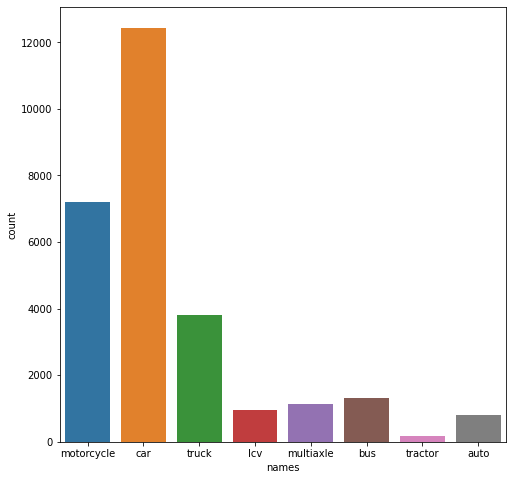

In [22]:
print(df['names'].value_counts())
plt.figure(figsize=(8,8))
sns.countplot(x='names', data=df)
plt.show()

In [23]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i] for i in range(len(df['labels']))) 

classes = df[['names','labels']].value_counts()
classes

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


names       labels
car         2         12439
motorcycle  4          7215
truck       7          3803
bus         1          1304
multiaxle   5          1138
lcv         3           962
auto        0           813
tractor     6           170
dtype: int64

In [24]:
classes= {0:'auto',1:'bus',2:'car',3:'lcv',4:'motorcycle',5:'multiaxle',6:'tractor',7:'truck'} 

In [25]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float64)
df['ymin'] = df['ymin'].astype(np.float64)
df['xmax'] = df['xmax'].astype(np.float64)
df['ymax'] = df['ymax'].astype(np.float64)

In [26]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

image_id  \
0  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...   
1  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...   
2  Highway_134_2020-07-30_jpg.rf.224c6114c0ee0714...   
3                                          00308.jpg   
4  Highway_1200_2020-07-30_jpg.rf.6ecbde087a6b3e6...   

                                            xml_path  \
0  /content/annotations/Highway_134_2020-07-30_jp...   
1  /content/annotations/Highway_134_2020-07-30_jp...   
2  /content/annotations/Highway_134_2020-07-30_jp...   
3                     /content/annotations/00308.xml   
4  /content/annotations/Highway_1200_2020-07-30_j...   

                                            img_path  labels   xmin   ymin  \
0  /content/images/Highway_134_2020-07-30_jpg.rf....       4  152.0   90.0   
1  /content/images/Highway_134_2020-07-30_jpg.rf....       2  185.0   70.0   
2  /content/images/Highway_134_2020-07-30_jpg.rf....       2   59.0  191.0   
3                          /content/images/00308.jpg       7   15.0   24.0   
4  /content/images/Highway_1200_2020-07-30_jpg.rf...       3  204.0  162.0   

    xmax   ymax  
0  160.0  110.0  
1  201.0   93.0  
2   99.0  260.0  
3  128.0  107.0  
4  257.0  272.0

In [27]:
print(df.shape)

(27844, 8)


In [28]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'])
print(len(df['image_id'].unique()))
print('-' * 20)
print(train_df.shape, val_df.shape)
print('-' * 20)
print(len(val_df['image_id'].unique()))
print('-' * 20)
print(len(train_df['image_id'].unique()))
print('-' * 20)

type(train_df), type(val_df) 

10097
--------------------
(22275, 8) (5569, 8)
--------------------
4186
--------------------
9240
--------------------


(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [29]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image_path = f'{self.image_dir}/{image_id}'
        if not os.path.exists(image_path):
            print(f"{image_path} not found")
            return None
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)


            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [30]:
#image and bounding box transforms
def get_transform_train():
    return A.Compose([
        
        A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
IMG_DIR = '/content/images'

train_dataset = VOCDataset(train_df, IMG_DIR , get_transform_train())
valid_dataset = VOCDataset(val_df, IMG_DIR, get_transform_valid())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

print(len(train_dataset))
print(len(valid_dataset))

9240
4186


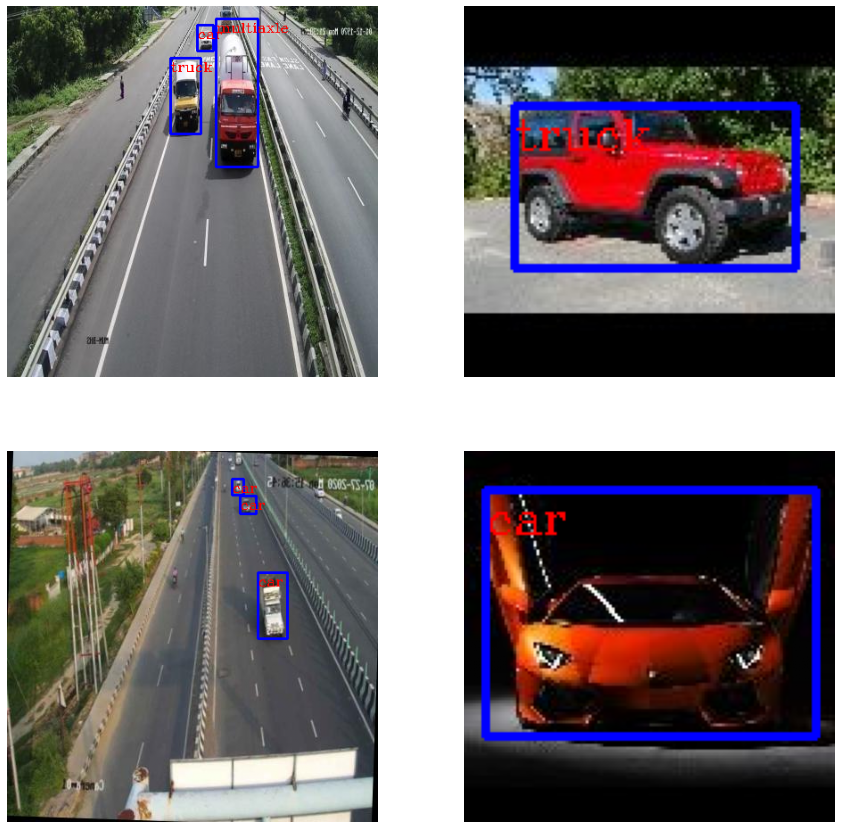

In [32]:
#plotting some images from our dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(255,0,0),1,cv2.LINE_AA)  
#     plt.subplots_adjust(pad=-5.0)
    plt.axis('off')
    plt.imshow(sample)

In [ ]:
# load a faster rcnn model; pre-trained on COCO dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 8

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [34]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.1, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
! pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
! git clone https://github.com/pytorch/vision.git
! cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../
!ls

In [36]:
# Model Training
from engine import train_one_epoch, evaluate
import utils


num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=150)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the valid dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [  0/289]  eta: 0:43:48  lr: 0.000447  loss: 2.2738 (2.2738)  loss_classifier: 2.0252 (2.0252)  loss_box_reg: 0.2027 (0.2027)  loss_objectness: 0.0332 (0.0332)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 9.0949  data: 1.1227  max mem: 26246
Epoch: [0]  [150/289]  eta: 0:02:30  lr: 0.052478  loss: 0.3118 (0.5099)  loss_classifier: 0.1420 (0.2658)  loss_box_reg: 0.1593 (0.2200)  loss_objectness: 0.0071 (0.0165)  loss_rpn_box_reg: 0.0052 (0.0076)  time: 1.0307  data: 0.0818  max mem: 26359
Epoch: [0]  [288/289]  eta: 0:00:01  lr: 0.100000  loss: 0.2937 (0.4089)  loss_classifier: 0.1228 (0.2024)  loss_box_reg: 0.1520 (0.1878)  loss_objectness: 0.0066 (0.0123)  loss_rpn_box_reg: 0.0053 (0.0063)  time: 1.0468  data: 0.0870  max mem: 26359
Epoch: [0] Total time: 0:05:04 (1.0541 s / it)
creating index...
index created!
Test:  [  0/131]  eta: 0:03:00  model_time: 0.4961 (0.4961)  evaluator_time: 0.0553 (0.0553)  time: 1.3764  data: 0.7502  max mem: 26359
Test:  [100/131]  eta: 0:00:19

In [37]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, './savedmodel/VehicleDetection.pth')